<div class="head0">
    <div class="head0__name">
        Diffusion equation with linear drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation by fast and accurate tensor based method with linear drift (Ornstein–Uhlenbeck process). Check for the 2th order solver.
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver as Solver1
from solver_tmp import SolverTmp as Solver2
from config import config

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

<div class="head1">
    <div class="head1__name">
        Parameters
    </div>
</div>

In [2]:
A = 1.
s = 1.
Dc = 0.5

def func_f0(x, t):
    m = 0.
    return A * (m - x)

def func_f1(x, t):
    return -A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    m = 0.
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-0.5 * x**2 / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

In [3]:
t_poi = 1000
t_min = 0.
t_max = 1.

x_poi = 500
x_min = -5.
x_max = +5.

m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

print('Time-space factor (h/l^2) : %-8.5f'%(h/l/l))

Time-space factor (h/l^2) : 2.50250 


<div class="head1">
    <div class="head1__name">
        Computations
    </div>
</div>

In [8]:
M = [100, 101]
N = list(np.arange(10, 51, 5, dtype=int))
E = {}
T = {}

def calc(SL, m, n):
    if not E.get(m): E[m] = []
    if not T.get(m): T[m] = []
        
    SL.set_grid_t(m, t_min, t_max, t_hst=1)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(Dc)
    SL.prep()
    SL.calc()

    T[m].append([SL._t_prep, SL._t_calc, SL._t_spec])
    E[m].append(SL._err)
        
for m in M:
    for n in list(N):
        print('----- Computation | m = %-6d | n = %-6d'%(m, n))
        time.sleep(1)
        calc(Solver1(d=1), m, n)

----- Computation | m = 100    | n = 10    


Solve: 100%|█| 99/99 [00:00<00:00, 1094.85step/s, | At T = 1.00e+00 : error = 2.40e-01]


----- Computation | m = 100    | n = 15    


Solve: 100%|█| 99/99 [00:00<00:00, 1523.55step/s, | At T = 1.00e+00 : error = 1.10e-01]


----- Computation | m = 100    | n = 20    


Solve: 100%|█| 99/99 [00:00<00:00, 1113.12step/s, | At T = 1.00e+00 : error = 6.81e-03]


----- Computation | m = 100    | n = 25    


Solve: 100%|█| 99/99 [00:00<00:00, 1024.78step/s, | At T = 1.00e+00 : error = 5.56e-03]


----- Computation | m = 100    | n = 30    


Solve: 100%|█| 99/99 [00:00<00:00, 1032.88step/s, | At T = 1.00e+00 : error = 5.50e-03]


----- Computation | m = 100    | n = 35    


Solve: 100%|█| 99/99 [00:00<00:00, 671.07step/s, | At T = 1.00e+00 : error = 5.50e-03]


----- Computation | m = 100    | n = 40    


Solve: 100%|█| 99/99 [00:00<00:00, 748.82step/s, | At T = 1.00e+00 : error = 5.50e-03]


----- Computation | m = 100    | n = 45    


Solve: 100%|█| 99/99 [00:00<00:00, 681.56step/s, | At T = 1.00e+00 : error = 5.50e-03]


----- Computation | m = 100    | n = 50    


Solve: 100%|█| 99/99 [00:00<00:00, 620.72step/s, | At T = 1.00e+00 : error = 5.50e-03]


----- Computation | m = 101    | n = 10    


Solve: 100%|█| 100/100 [00:00<00:00, 1948.14step/s, | At T = 1.00e+00 : error = 2.40e-01]


----- Computation | m = 101    | n = 15    


Solve: 100%|█| 100/100 [00:00<00:00, 1533.32step/s, | At T = 1.00e+00 : error = 1.10e-01]


----- Computation | m = 101    | n = 20    


Solve: 100%|█| 100/100 [00:00<00:00, 1349.80step/s, | At T = 1.00e+00 : error = 6.78e-03]


----- Computation | m = 101    | n = 25    


Solve: 100%|█| 100/100 [00:00<00:00, 661.55step/s, | At T = 1.00e+00 : error = 5.50e-03]


----- Computation | m = 101    | n = 30    


Solve: 100%|█| 100/100 [00:00<00:00, 973.83step/s, | At T = 1.00e+00 : error = 5.44e-03]


----- Computation | m = 101    | n = 35    


Solve: 100%|█| 100/100 [00:00<00:00, 728.17step/s, | At T = 1.00e+00 : error = 5.44e-03]


----- Computation | m = 101    | n = 40    


Solve: 100%|█| 100/100 [00:00<00:00, 509.60step/s, | At T = 1.00e+00 : error = 5.44e-03]


----- Computation | m = 101    | n = 45    


Solve: 100%|█| 100/100 [00:00<00:00, 558.25step/s, | At T = 1.00e+00 : error = 5.44e-03]


----- Computation | m = 101    | n = 50    


Solve: 100%|█| 100/100 [00:00<00:00, 623.12step/s, | At T = 1.00e+00 : error = 5.44e-03]


<div class="head1">
    <div class="head1__name">
        Results
    </div>
</div>

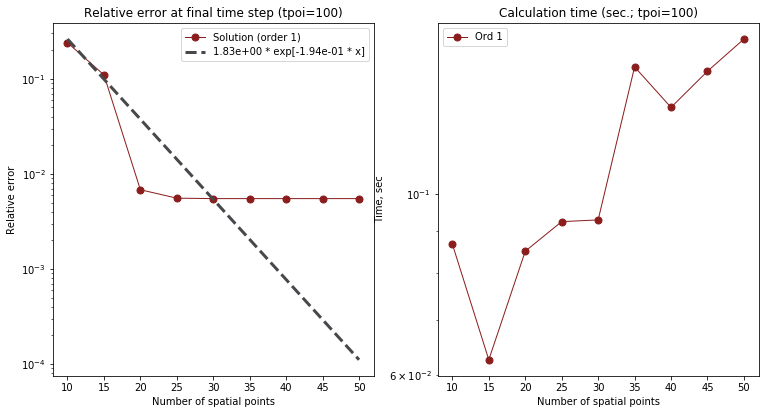

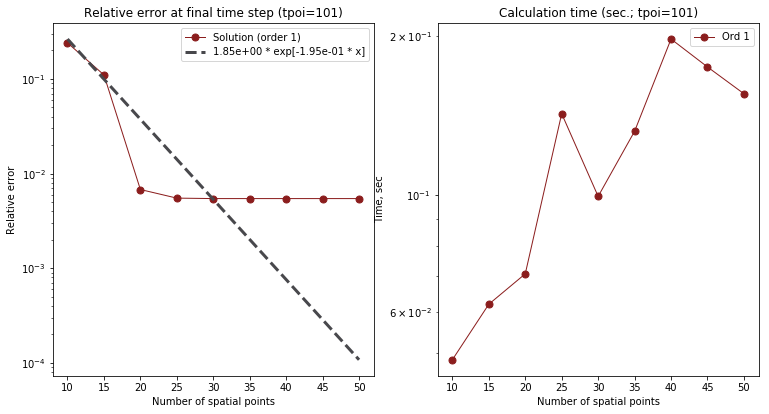

In [16]:
def show(lims):

    for m in M:
        x = np.array(N.copy())
        y = np.array(E[m].copy())
        t = T[m].copy()

        xe = x[lims[m][0]:lims[m][1]]
        ye = y[lims[m][0]:lims[m][1]]

        b, a = np.polyfit(xe, np.log(ye), 1, w=np.sqrt(ye))
        a = np.exp(a)
        z1 = a * np.exp(b * x)

        fig = plt.figure(**config['plot']['fig']['base_1_2'])
        grd = mpl.gridspec.GridSpec(**config['plot']['grid']['base_1_2'])
        ax1 = fig.add_subplot(grd[0, 0])
        ax2 = fig.add_subplot(grd[0, 1])

        opts = config['plot']['line']['calc'].copy()
        opts['label'] = 'Solution (order 1)'
        ax1.plot(x, y, **opts)

        opts = config['plot']['line']['init'].copy()
        opts['label'] = '%8.2e * exp[%8.2e * x]'%(a, b)
        ax1.plot(x, z1, **opts)

        ax1.set_title('Relative error at final time step (tpoi=%d)'%m)
        ax1.set_xlabel('Number of spatial points')
        ax1.set_ylabel('Relative error')
        ax1.legend(loc='best')
        ax1.semilogy()

        opts = config['plot']['line']['calc'].copy()
        opts['label'] = 'Ord 1'
        ax2.plot(N, [t_[1] for t_ in t], **opts)
        ax2.semilogy()
        ax2.set_title('Calculation time (sec.; tpoi=%d)'%m)
        ax2.set_xlabel('Number of spatial points')
        ax2.set_ylabel('Time, sec')
        ax2.legend(loc='best')

        plt.show()
        
show({
    100: [1, 6],
    101: [1, 6],
})

<div class="end"></div>